# Импорты

In [ ]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, CatBoostError
from sklearn.model_selection import train_test_split

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150

# Датасет

[Source](https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data)

- Переназвать столбцы, убрав незначимые
- Замена кэггла

## Modeling

In [2]:
orig_df = pd.read_csv("data/Loan_Default.csv")
orig_df

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0


In [ ]:
df = orig_df.sample(30000, random_state=42)

cols_to_remove = ["ID", "rate_of_interest", "Interest_rate_spread"]
target = "Status"

cat_cols = list(df.select_dtypes(object).columns)
df[cat_cols] = df[cat_cols].astype(str)


X = df.drop(
    columns=[
        target,
        *cols_to_remove,
        "Upfront_charges",
    ]
)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = list(X.select_dtypes(object).columns)
model = CatBoostClassifier(cat_features=cat_cols, allow_writing_files=False, verbose=False)
model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_score(y_true=y_test, y_pred=pred)

0.7449879711307137

<Axes: >

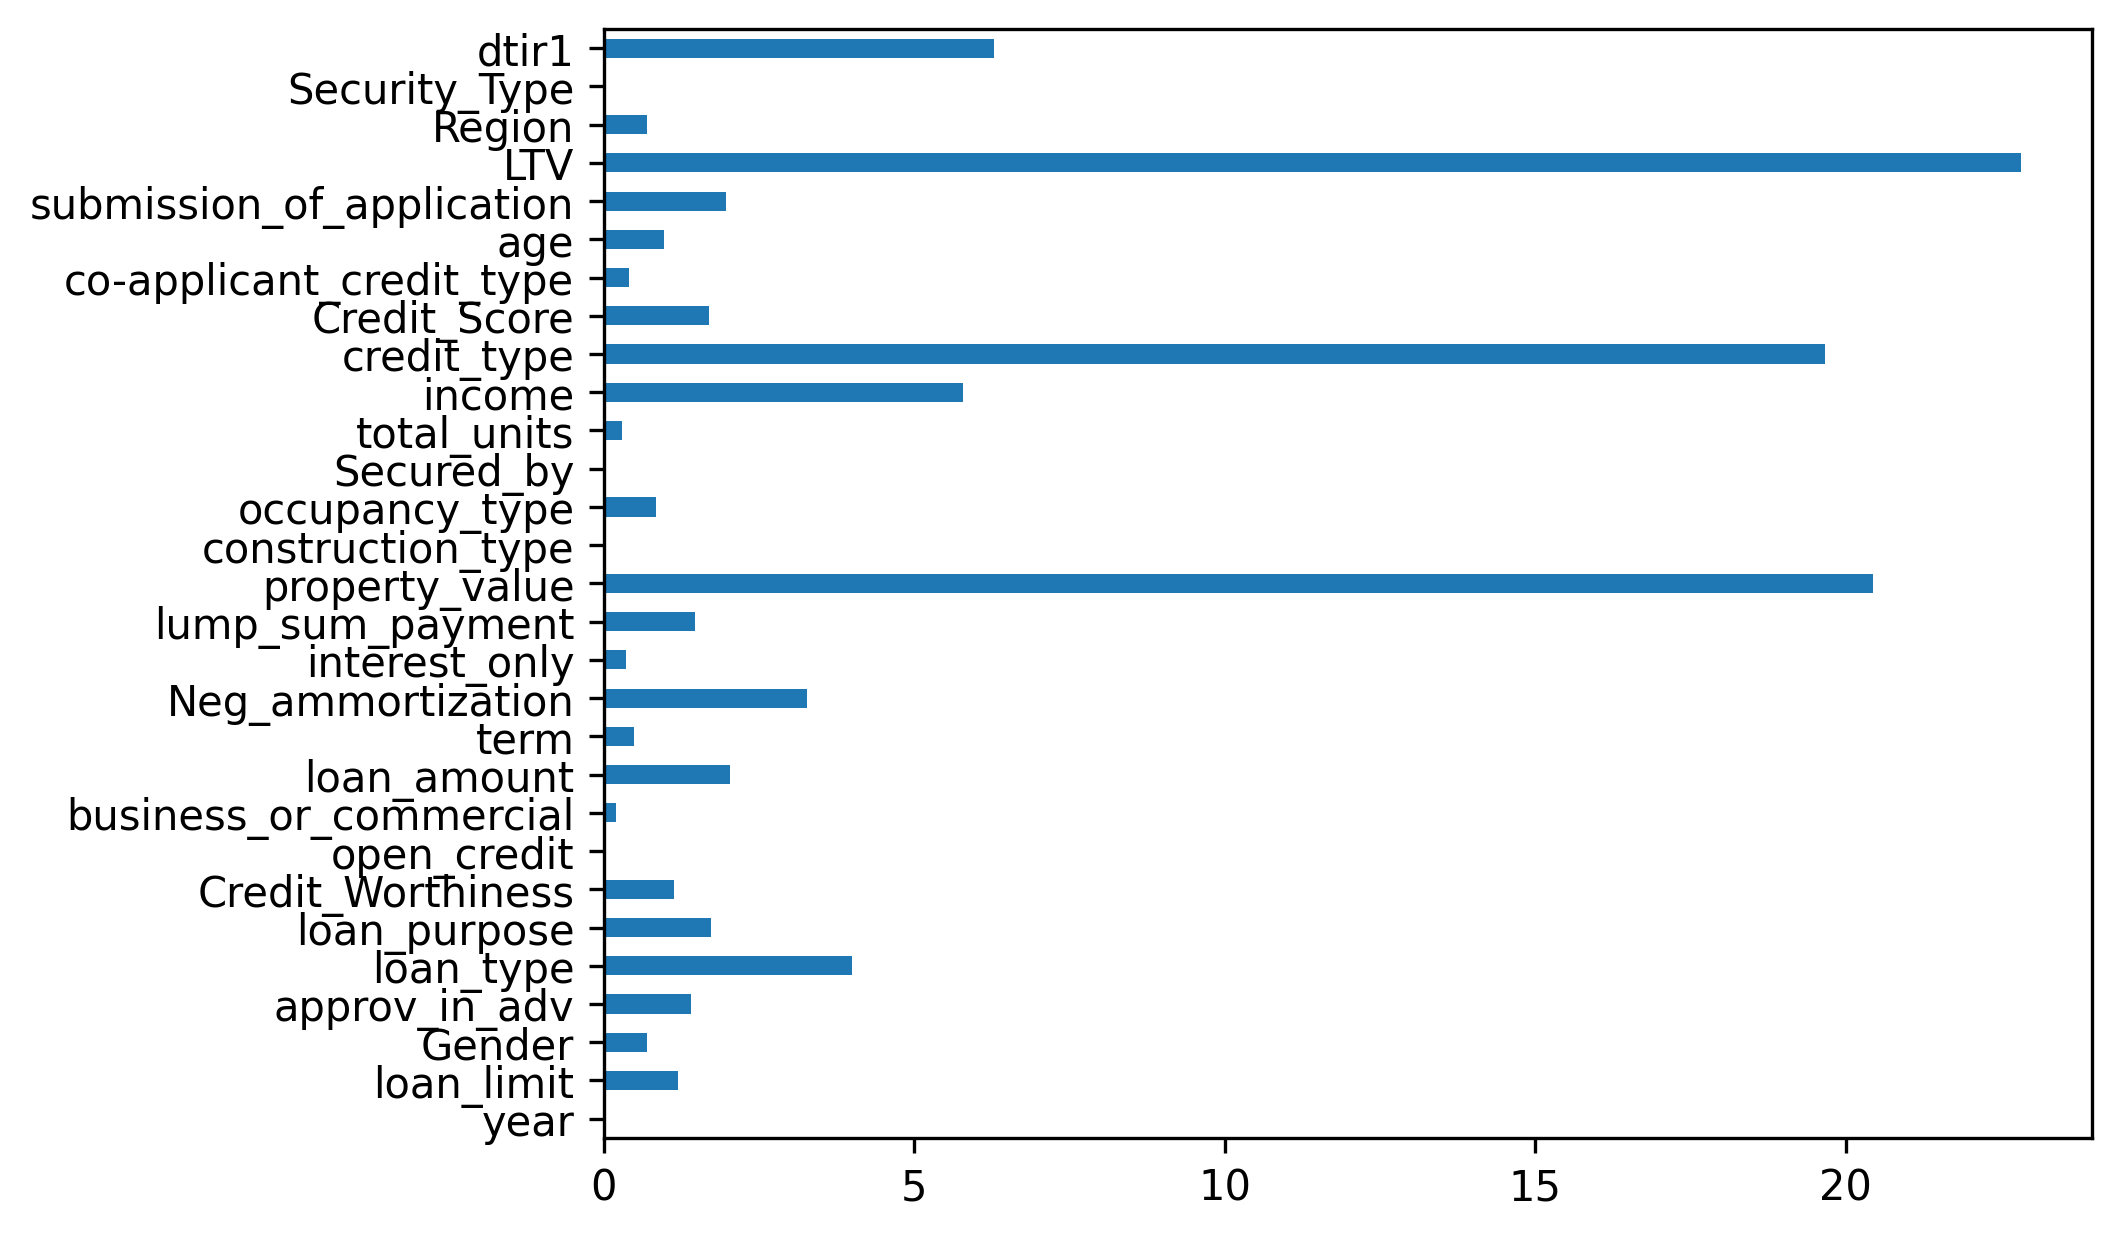

In [4]:
pd.Series(model.feature_importances_, index=X.columns).plot.barh()

Самая важная фича Upfront_charges - без него для базового кэтбуста метрика падает с f1 0.96 до 0.74

In [ ]:
def show_best_feats(df: pd.DataFrame) -> None:
    X = df.drop(columns=[target, "ID"])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    cols: list[str] = []
    metrics: list[float] = []

    for col in tqdm(X_train.columns):
        X_train_sel = X_train[[col]]
        X_test_sel = X_test[[col]]

        model = CatBoostClassifier(
            cat_features=list(X_train_sel.select_dtypes(object).columns), allow_writing_files=False, verbose=False
        )
        try:
            model.fit(X_train_sel, y_train)
        except CatBoostError:
            continue

        pred = model.predict(X_test_sel)
        metric = f1_score(y_true=y_test, y_pred=pred)
        if not metric:
            continue
        metrics.append(metric)
        cols.append(col)

    print(pd.Series(metrics, index=cols).sort_values(ascending=False))


show_best_feats(df)

100%|██████████| 32/32 [00:23<00:00,  1.39it/s]

rate_of_interest        1.000000
Interest_rate_spread    1.000000
Upfront_charges         0.965517
credit_type             0.551724
property_value          0.545455
LTV                     0.542373
dtir1                   0.530120
income                  0.188679
lump_sum_payment        0.173913
loan_amount             0.120000
Credit_Score            0.044444
dtype: float64


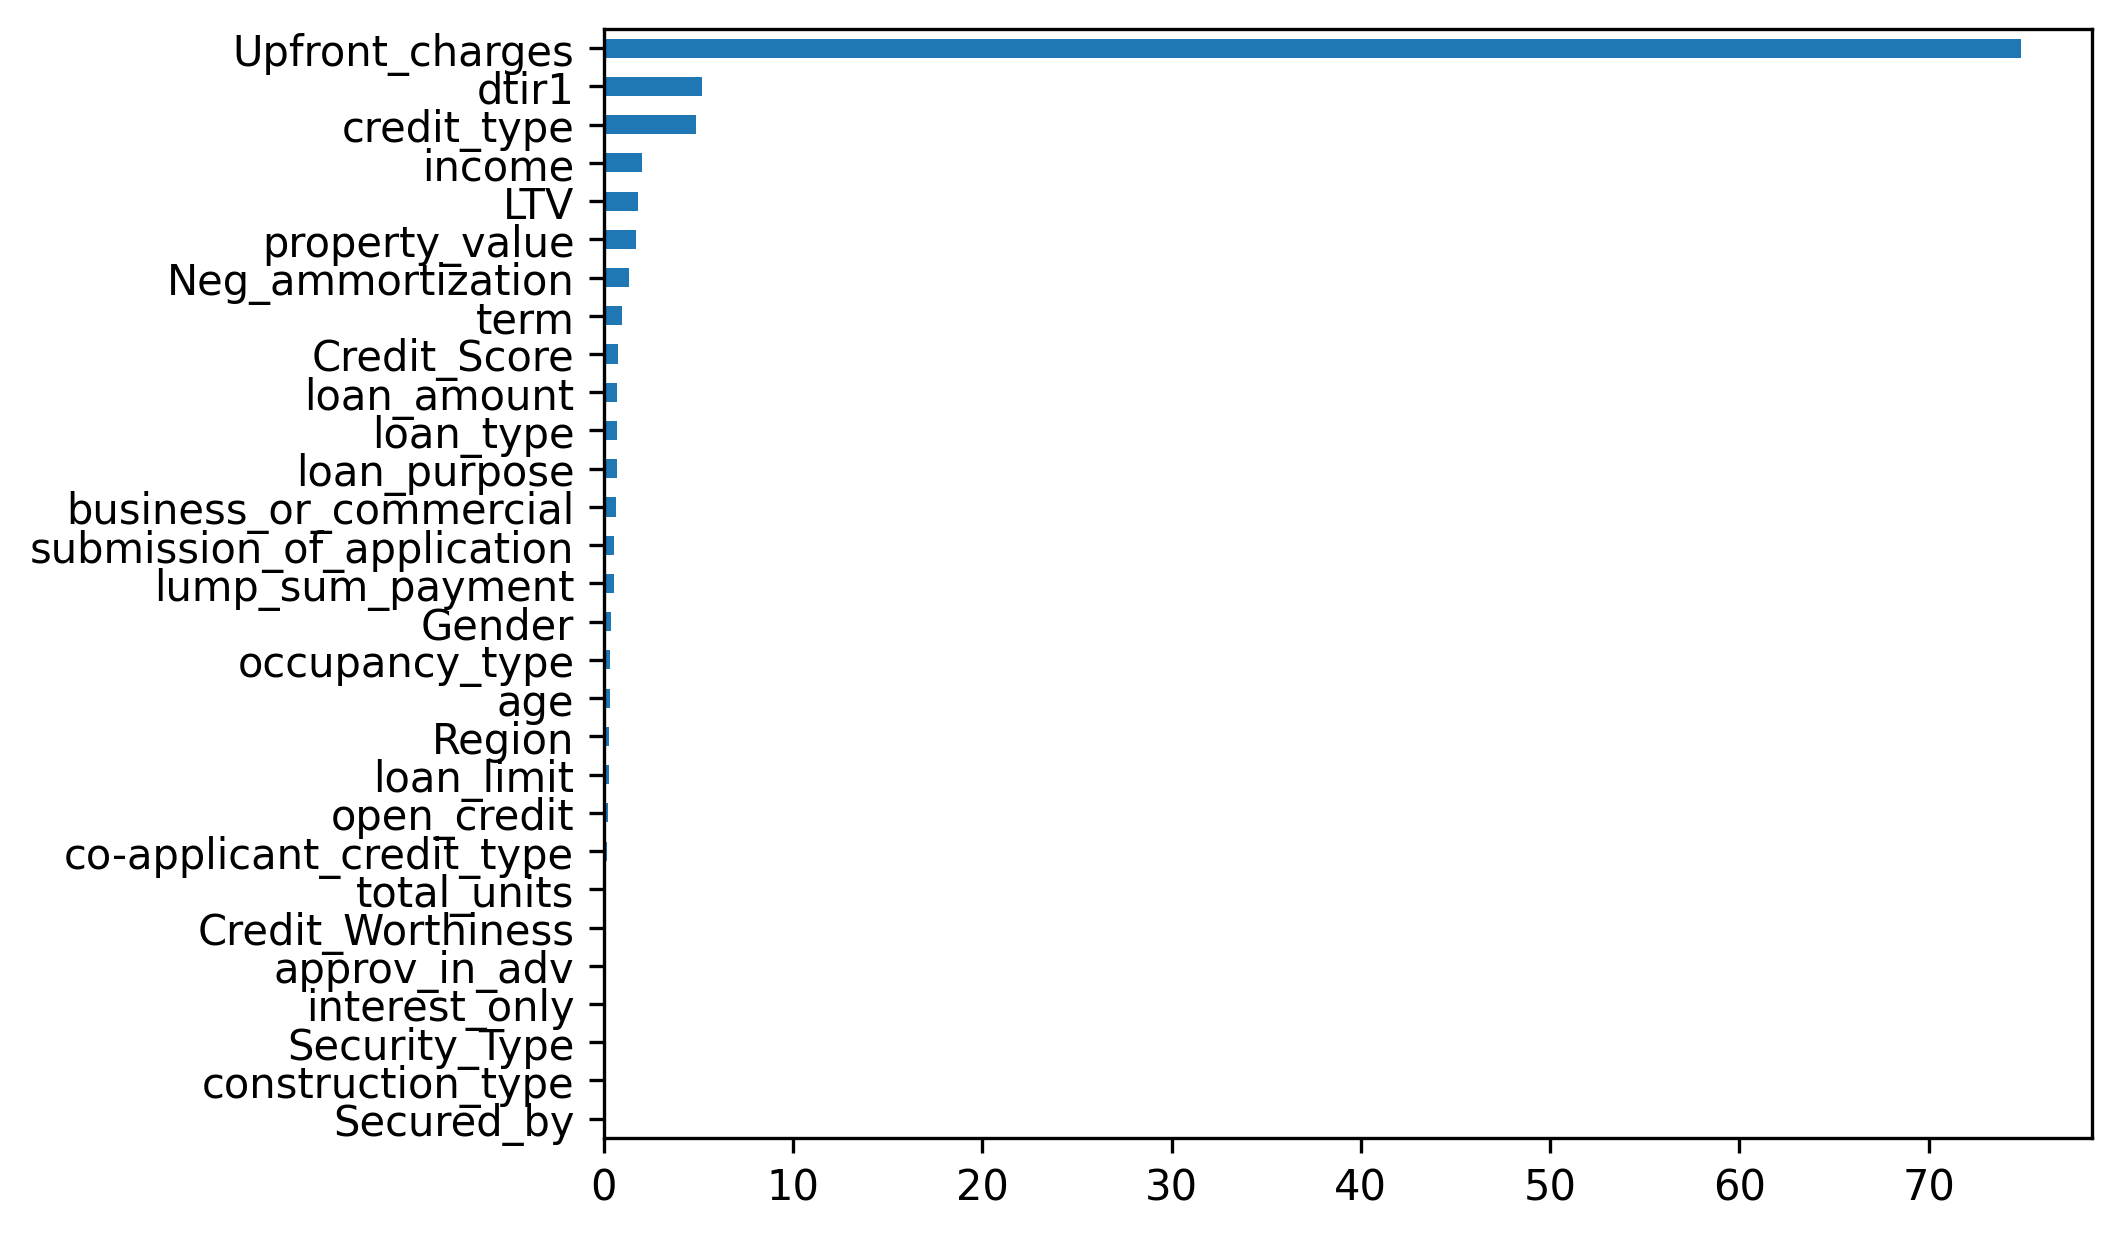

In [28]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances[importances > 0]
ax = importances.sort_values().plot.barh()
# ax.set_xscale('log')
plt.show()

# Сэмпл датасета с текстовыми фичами

In [ ]:
from create_llm_feats import OUTPUT_PATH


orig_df = pd.read_csv(OUTPUT_PATH)
orig_df

,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,...,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1,essay
0,2019,cf,Female,nopre,type2,p3,l1,nopc,b/c,116500,...,679,CIB,45-54,to_inst,84.420290,North,direct,0,41.0,"""Hello! I'm a dedicated individual working har..."
1,2019,cf,Sex Not Available,pre,type1,p4,l1,nopc,nob/c,236500,...,853,EXP,25-34,to_inst,88.246269,south,direct,0,44.0,"""Hi there! I’m a professional with a stable jo..."
2,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,136500,...,598,EXP,65-74,to_inst,19.279661,south,direct,0,41.0,"""Greetings! I’m currently navigating a low-inc..."
3,2019,cf,Female,nopre,type1,p3,l1,nopc,nob/c,256500,...,776,EXP,65-74,to_inst,36.228814,North,direct,0,32.0,"""Hello! I’m a hardworking woman with a stable ..."
4,2019,cf,Female,nopre,type1,p1,l1,nopc,nob/c,686500,...,653,CIB,35-44,not_inst,81.921241,North,direct,0,48.0,"""Hi! I’m a motivated individual with a steady ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,296500,...,771,CIB,45-54,not_inst,69.275701,North,direct,0,14.0,"""Hi! I'm a successful man with a robust income..."
9996,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,76500,...,655,CIB,55-64,to_inst,55.434783,North,direct,0,37.0,"""Hello! I’m a low-income individual, starting ..."
9997,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,326500,...,650,CIB,65-74,to_inst,58.512545,south,direct,1,34.0,"""Hi. Life has me in a mixed place, producing a..."
9998,2019,cf,Sex Not Available,nopre,type1,p4,l1,nopc,nob/c,196500,...,556,CIB,65-74,to_inst,59.908537,south,direct,0,38.0,"""Hello! I identify as someone looking for stab..."


In [14]:
target = "Status"

df = orig_df.copy()
cat_cols = list(df.select_dtypes(object).columns)
df[cat_cols] = df[cat_cols].astype(str)


X = df.drop(columns=[target, "Upfront_charges"])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = list(X.select_dtypes(object).columns)
model = CatBoostClassifier(cat_features=cat_cols, allow_writing_files=False, verbose=False)
model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_score(y_true=y_test, y_pred=pred)

0.7173333333333334

In [21]:
import torch
from transformers import BertTokenizer, BertModel

model_name = "bert-base-uncased"
tokenizer: BertTokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

text = list(df["Upfront_charges"])

inputs = tokenizer(text, return_tensors="pt", padding=True)
with torch.no_grad():  # Disable gradient calculation
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
cls_embedding = last_hidden_states[:, 0, :]


In [ ]:
target = "Status"

df = orig_df.copy()
cat_cols = list(df.select_dtypes(object).columns)
df[cat_cols] = df[cat_cols].astype(str)

X = df.drop(columns=[target, "Upfront_charges"])
emb_df = pd.DataFrame(cls_embedding)
X = pd.concat((X, emb_df), axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = list(X.select_dtypes(object).columns)
model = CatBoostClassifier(cat_features=cat_cols, allow_writing_files=False, verbose=False)
model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_score(y_true=y_test, y_pred=pred)

0.8637873754152824